In [29]:
!pip install rouge
!pip install rouge-score

import numpy as np
import pandas as pd
import re
import string
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from rouge import Rouge
from rouge_score import rouge_scorer

# Preprocessing

In [30]:
train_data = pd.read_csv('../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
val_data = pd.read_csv('../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
test_data = pd.read_csv('../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [31]:
train_data = train_data.drop(['id'], axis=1)
train_data = train_data.reset_index(drop=True)
val_data = val_data.drop(['id'], axis=1)
val_data = val_data.reset_index(drop=True)
test_data = test_data.drop(['id'], axis=1)
test_data = test_data.reset_index(drop=True)

In [32]:
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

In [33]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')
    
clean_texts = []
for text in train_data.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaning Summaries Complete
Cleaning Texts Complete


In [35]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:40000]
clean_df['summary'] = clean_summaries[:40000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

# Tokenizing Text And Summary Data

In [36]:
train_x, val_x, train_y, val_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.2, random_state=0)
del clean_df

In [37]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    if value < thresh:
        count += 1

In [ ]:
t_max_features = total_count - count

In [39]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    if value < thresh:
        count += 1

In [ ]:
s_max_features = total_count-count

In [41]:
maxlen_text = 800
maxlen_summ = 150

In [42]:
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [43]:
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [44]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (32000, 800)
Target Values Shape (32000, 150)
Test Sequence (8000, 800)
Target Test Shape (8000, 150)


# Pretrained Embedding

In [45]:
embeding_index = {}
embed_dim = 100
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [46]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [47]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [48]:
del embeding_index

# Model Architecture

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 800, 100)     7780900     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 256), (None, 234496      embedding_2[0][0]                
____________________________________________________________________________________________

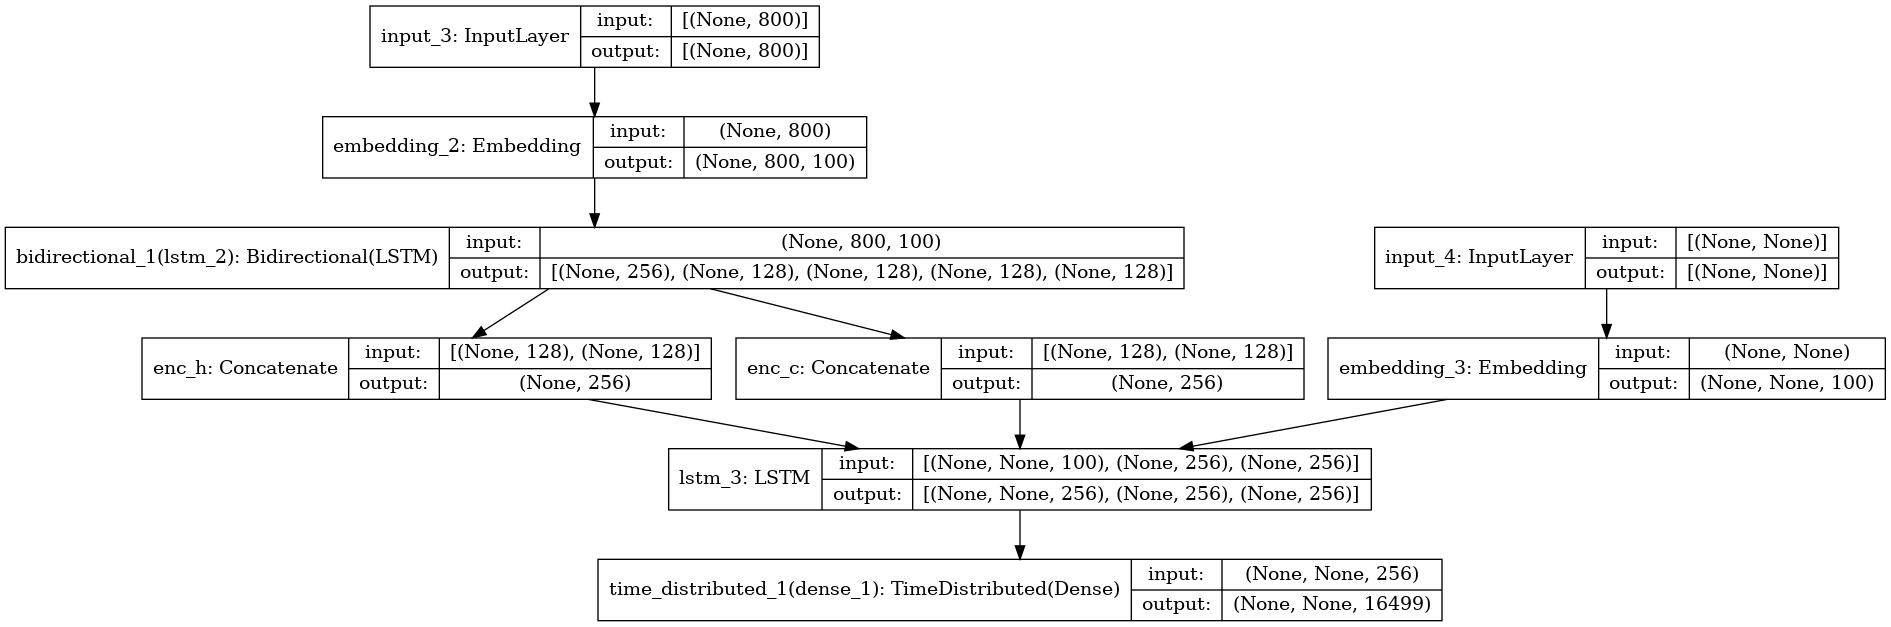

In [49]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [60]:
class RougeMetric(tf.keras.metrics.Metric):
    def __init__(self, name='rouge', **kwargs):
        super(RougeMetric, self).__init__(name=name, **kwargs)
        self.rouge1 = self.add_weight(name='rouge1', initializer='zeros')
        self.rouge2 = self.add_weight(name='rouge2', initializer='zeros')
        self.rougeL = self.add_weight(name='rougeL', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert from one-hot to indices
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        # Use tf.py_function to apply Python functions inside the TensorFlow graph
        scores = tf.py_function(self.compute_rouge, [y_true, y_pred], [tf.float32, tf.float32, tf.float32])

        # Update the metric states with the computed scores
        self.rouge1.assign_add(scores[0])
        self.rouge2.assign_add(scores[1])
        self.rougeL.assign_add(scores[2])
        self.count.assign_add(1)

    def compute_rouge(self, y_true, y_pred):
        # Convert Tensor to NumPy arrays (for use in the Python `rouge_scorer`)
        y_true_np = y_true.numpy()
        y_pred_np = y_pred.numpy()

        rouge1_total = 0.0
        rouge2_total = 0.0
        rougeL_total = 0.0
        num_samples = len(y_true_np)

        for i in range(num_samples):
            true_sentence = ' '.join(map(str, y_true_np[i]))
            pred_sentence = ' '.join(map(str, y_pred_np[i]))

            # Compute ROUGE scores
            scores = self.scorer.score(true_sentence, pred_sentence)
            rouge1_total += scores['rouge1'].fmeasure
            rouge2_total += scores['rouge2'].fmeasure
            rougeL_total += scores['rougeL'].fmeasure

        # Return the average ROUGE scores
        return rouge1_total / num_samples, rouge2_total / num_samples, rougeL_total / num_samples

    def result(self):
        return {
            'rouge1': self.rouge1 / self.count,
            'rouge2': self.rouge2 / self.count,
            'rougeL': self.rougeL / self.count
        }

    def reset_state(self):
        self.rouge1.assign(0)
        self.rouge2.assign(0)
        self.rougeL.assign(0)
        self.count.assign(0)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=[RougeMetric()])

In [61]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=50, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/50
250/250 - 580s - loss: 1.9345 - rouge1: 0.6810 - rouge2: 0.6775 - rougeL: 0.6810 - val_loss: 1.8947 - val_rouge1: 0.6825 - val_rouge2: 0.6795 - val_rougeL: 0.6825
Epoch 2/50
250/250 - 574s - loss: 1.8950 - rouge1: 0.6808 - rouge2: 0.6774 - rougeL: 0.6808 - val_loss: 1.8685 - val_rouge1: 0.6824 - val_rouge2: 0.6795 - val_rougeL: 0.6824
Epoch 3/50
250/250 - 572s - loss: 1.8664 - rouge1: 0.6807 - rouge2: 0.6774 - rougeL: 0.6807 - val_loss: 1.8508 - val_rouge1: 0.6823 - val_rouge2: 0.6794 - val_rougeL: 0.6823
Epoch 4/50
250/250 - 571s - loss: 1.8430 - rouge1: 0.6806 - rouge2: 0.6774 - rougeL: 0.6806 - val_loss: 1.8354 - val_rouge1: 0.6823 - val_rouge2: 0.6795 - val_rougeL: 0.6823
Epoch 5/50
250/250 - 570s - loss: 1.8234 - rouge1: 0.6805 - rouge2: 0.6774 - rougeL: 0.6805 - val_loss: 1.8254 - val_rouge1: 0.6822 - val_rouge2: 0.6794 - val_rougeL: 0.6822
Epoch 6/50
250/250 - 570s - loss: 1.8062 - rouge1: 0.6805 - rouge2: 0.6774 - rougeL: 0.6805 - val_loss: 1.8160 - val_rouge1: 0.682

# Testing

In [62]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [63]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

In [64]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
hyps = []
with open('./result2.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(len(test_inputs) - 1):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

# ROUGE score

In [66]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.40261050457871027,
  'p': 0.4775706044391582,
  'f': 0.44343059373290962},
 'rouge-2': {'r': 0.3690056052346893,
  'p': 0.33125980726519811,
  'f': 0.317965523780110973},
 'rouge-l': {'r': 0.29584795718759787,
  'p': 0.3616769763767375,
  'f': 0.33431536990901444}}